In [1]:
# ===============================
# IMPORTS
# ===============================
import pandas as pd
import matplotlib.pyplot as plt
import timeit
from collections import Counter
import csv
import string

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

import cv2
import numpy as np
import os
import imutils
from imutils.contours import sort_contours

In [2]:

# ===============================
# SETTINGS
# ===============================
from pandas import DataFrame


img_size = 32
max_train = 200000
max_val = 50000

max_images = (max_train + max_val)

train_dir = "dataset/train_v2/train"
test_dir = "dataset/test_v2/test"
val_dir   = "dataset/validation_v2/validation"

train_csv_path = "dataset/written_name_train_v2.csv"
test_csv_path = "dataset/written_name_test_v2.csv"
val_csv_path   = "dataset/written_name_validation_v2.csv"

# ===============================
# LOAD CSV LABELS
# ===============================
train_csv: DataFrame = pd.read_csv(train_csv_path)
test_csv: DataFrame = pd.read_csv(test_csv_path)
val_csv: DataFrame   = pd.read_csv(val_csv_path)

# Ensure labels are strings
train_csv["IDENTITY"] = train_csv["IDENTITY"].astype(str)
test_csv["IDENTITY"] = test_csv["IDENTITY"].astype(str)
val_csv["IDENTITY"]   = val_csv["IDENTITY"].astype(str)

train_file_to_label = dict(zip(train_csv['FILENAME'], train_csv['IDENTITY']))
test_file_to_label = dict(zip(test_csv['FILENAME'], test_csv['IDENTITY']))
val_file_to_label   = dict(zip(val_csv['FILENAME'], val_csv['IDENTITY']))

In [3]:
# ===============================
# DATASET EXPLORATION
# ===============================
print("\nTrain CSV\n",train_csv.head())
print("\nTest CSV\n",test_csv.head())
print("\nValidation CSV\n",val_csv.head())

# Counter for letters
letter_counts = Counter()

with open(train_csv_path, newline="", encoding="utf-8") as f:
    reader = csv.reader(f)
    for row in reader:
        # Join all columns into one string
        text = " ".join(row).lower()

        # Keep only alphabet letters
        for ch in text:
            if ch in string.ascii_lowercase:
                letter_counts[ch] += 1

# Print results sorted alphabetically
for letter in string.ascii_lowercase:
    print(f"{letter}: {letter_counts[letter]}")



Train CSV
           FILENAME   IDENTITY
0  TRAIN_00001.jpg  BALTHAZAR
1  TRAIN_00002.jpg      SIMON
2  TRAIN_00003.jpg      BENES
3  TRAIN_00004.jpg    LA LOVE
4  TRAIN_00005.jpg     DAPHNE

Test CSV
         FILENAME  IDENTITY
0  TEST_0001.jpg     KEVIN
1  TEST_0002.jpg  CLOTAIRE
2  TEST_0003.jpg      LENA
3  TEST_0004.jpg     JULES
4  TEST_0005.jpg   CHERPIN

Validation CSV
               FILENAME    IDENTITY
0  VALIDATION_0001.jpg       BILEL
1  VALIDATION_0002.jpg  LAUMIONIER
2  VALIDATION_0003.jpg         LEA
3  VALIDATION_0004.jpg   JEAN-ROCH
4  VALIDATION_0005.jpg        RUPP
a: 600618
b: 45966
c: 68144
d: 60504
e: 270852
f: 18288
g: 370096
h: 61724
i: 504863
j: 346765
k: 14082
l: 161202
m: 83719
n: 498167
o: 136385
p: 360564
q: 5166
r: 479325
s: 91419
t: 432511
u: 96417
v: 25094
w: 5505
x: 11342
y: 30831
z: 14177


✅ Loaded image shape: (31, 284, 3)


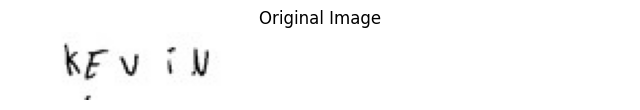

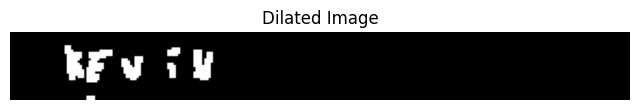

➡️ Contour 0: ROI shape = (18, 11)
➡️ Contour 2: ROI shape = (17, 14)
➡️ Contour 3: ROI shape = (13, 12)
➡️ Contour 4: ROI shape = (9, 6)
➡️ Contour 5: ROI shape = (6, 8)
➡️ Contour 6: ROI shape = (16, 11)


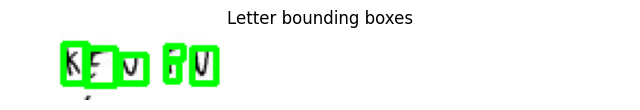

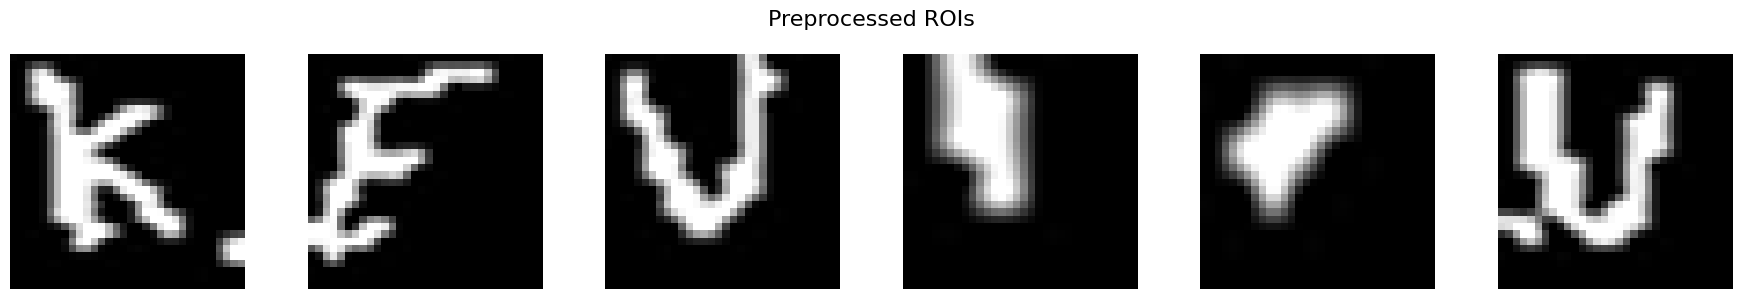

In [4]:
# ===============================
# MANUAL LETTER SPLITTER
# ===============================

def get_bounding_boxes(img_path: str, show_plts = False):
    if not os.path.exists(img_path):
        print("❌ Error: File not found at", img_path)
        return [], None

    image = cv2.imread(img_path)
    if image is None:
        print("❌ Error: Could not read the image. Check file format or path.")
        return [], None
    
    if show_plts:
        print("✅ Loaded image shape:", image.shape)


        plt.figure(figsize=(8,6))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("Original Image")
        plt.show()

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Threshold + dilation
    # Flip image to be black on white instead of white on black 
    # Fill holes in contours
    _, thresh1 = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, kernel=filter_kernel, iterations=2)

    if show_plts:
        plt.figure(figsize=(8,6))
        plt.imshow(cv2.cvtColor(dilated, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("Dilated Image")
        plt.show()

    # Find contours
    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    if len(cnts) == 0:
        if show_plts:
            print("Detected 0 letters: ", img_path)
        return image, []

    cnts = sort_contours(cnts, method="left-to-right")[0]

    letters = []

    for i, c in enumerate(cnts):
        if cv2.contourArea(c) < 10:
            continue
        x, y, w, h = cv2.boundingRect(c)

        # add buffer area
        w += 2
        h += 2

        x -= 1
        y -= 1

        # Extract ROI
        roi = gray[y:y+h, x:x+w]

        # Safety check
        if roi.size == 0 or roi.shape[0] == 0 or roi.shape[1] == 0:
            if show_plts:
                print(f"⚠️ Skipping empty ROI at contour {i} -> x={x}, y={y}, w={w}, h={h}")
            continue
        if show_plts:
            print(f"➡️ Contour {i}: ROI shape = {roi.shape}")

        # Draw bounding box
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Preprocess ROI for CNN
        thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (img_size, img_size), interpolation=cv2.INTER_CUBIC)
        thresh = thresh.astype("float32") / 255.0
        # thresh = np.expand_dims(thresh, axis=-1)  # (32, 32, 1)
        # thresh = np.expand_dims(thresh, axis=0)   # (1, 32, 32, 1)
        # thresh = np.squeeze(thresh)               # ()

        letters.append(thresh)
    return image, letters

def plot_processed_images(images, img_size=32):
    """
    Plots a list of preprocessed images as subplots.

    Parameters:
        images: list or array of preprocessed images, shape can be (N, H, W, 1) or (N, H, W)
        img_size: size of the images (for reshaping if needed)
    """
    # Ensure images are 2D for plotting
    processed_images = []
    for im in images:
        if im.ndim == 4:  # (1, H, W, 1)
            processed_images.append(im[0, :, :, 0])
        elif im.ndim == 3 and im.shape[-1] == 1:  # (H, W, 1)
            processed_images.append(im[:, :, 0])
        else:
            processed_images.append(im)

    n = len(processed_images)
    cols = 6
    rows = (n // cols) + int(n % cols != 0)

    plt.figure(figsize=(3*cols, 3*rows))
    for i, roi in enumerate(processed_images):
        plt.subplot(rows, cols, i+1)
        plt.imshow(roi, cmap='gray')
        plt.axis('off')
    plt.suptitle("Preprocessed ROIs", fontsize=16)
    plt.tight_layout()
    plt.show()  

filter_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))

example_image = os.path.join(r"dataset\test_v2\test", "TEST_0001.jpg")
image, counturs = get_bounding_boxes(example_image, show_plts=True)

plt.figure(figsize=(8,6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) # type: ignore
plt.axis('off')
plt.title("Letter bounding boxes")
plt.show()

plot_processed_images(images=counturs)


In [5]:
# ===============================
# BENCHMARK
# ===============================

example_image = os.path.join(r"dataset\test_v2\test", "TEST_0001.jpg")

def wrapper():
    get_bounding_boxes(example_image)
time = timeit.timeit(wrapper, number=50)
print("Time to run: ",time)
print("Time for all images: ",time * (max_train + max_val))


Time to run:  0.02377610000257846
Time for all images:  5944.025000644615


In [6]:
# ===============================
# LOGISTIC REGRESSION PREP
# ===============================
def logistic_image_prep(file_name,folder_path,file_label, debug=False):
    example_image = os.path.join(folder_path, file_name)
    image, counturs = get_bounding_boxes(example_image, show_plts=debug)

    if debug:
        plt.figure(figsize=(8,6))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) # type: ignore
        plt.axis('off')
        plt.show()

        plot_processed_images(images=counturs)

    if debug:
        print(train_file_to_label[file_name])

    if len(file_label) != len(counturs): # type: ignore
        if debug:
            print("Mismatch in counturs and label")
        return 1
    return [[img, label] for img, label in zip(counturs, file_label)]  # type: ignore 
            # (letter[], letterLabel)



In [7]:

# ===============================
# CREATE TRAINING SET
# ===============================
print("Creating Training Sets")
errors = 0
images = []
for idx, file in train_csv.iterrows():
    file_label = file["IDENTITY"]
    file_name = file["FILENAME"]
    res = logistic_image_prep(file_name=file_name,folder_path=r"dataset\train_v2\train",file_label=file_label)
    if res != 1:
        images.extend(res)
    else:
        errors += 1

    if len(images) >= max_train:
        print("Rows Processed: ", idx)
        print("% of full dataset: ", round(idx / len(train_csv)*100,2)) # type: ignore
        break

print("Errors: ", errors)
print("Images:",len(images))

arr = np.array(images, dtype=object)   # shape (3, 2)


# Split into two arrays (columns)
x_train = np.stack(arr[:, 0], axis=0)    # type: ignore
y_train = arr[:, 1]   # second column

print(x_train.shape)


Creating Training Sets
Rows Processed:  70382
% of full dataset:  21.27
Errors:  38941
Images: 200001
(200001, 32, 32)


In [8]:
# ===============================
# CREATE VALIDATION SET
# ===============================
print("Creating validation Sets")
errors = 0
images = []
for idx, file in val_csv.iterrows():
    file_label = file["IDENTITY"]
    file_name = file["FILENAME"]
    res = logistic_image_prep(file_name=file_name,folder_path=r"dataset\validation_v2\validation",file_label=file_label)
    if res != 1:
        images.extend(res)
    else:
        errors += 1

    if len(images) >= max_val:
        print("Rows Processed: ", idx)
        print("% of full dataset: ", round(idx / len(test_csv)*100,2)) # type: ignore
        break

print("Errors: ", errors)
print("Images:",len(images))

arr = np.array(images, dtype=object)   # shape (3, 2)

# Split into two arrays (columns)
x_val = np.stack(arr[:, 0], axis=0) # type: ignore
y_val = arr[:, 1]   # second column

print(x_train.shape)


Creating validation Sets
Rows Processed:  17483
% of full dataset:  42.26
Errors:  9622
Images: 50003
(200001, 32, 32)


In [9]:
# Flatten each 28x28 image into a 784-length vector
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_val_flat = x_val.reshape(x_val.shape[0], -1)

# Normalize pixel values to range [0, 1]
x_train_flat = x_train_flat.astype('float32') / 255.0
x_val_flat = x_val_flat.astype('float32') / 255.0

In [10]:
model = SVC(verbose=True)

# Train the model
model.fit(x_train_flat, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [11]:
# Accuracy on the test set
accuracy = model.score(x_val_flat, y_val)
print(f"Test Accuracy: {accuracy:.4f}")

# Predictions for detailed evaluation
y_pred = model.predict(x_val_flat)

Test Accuracy: 0.9128


In [12]:
cm = confusion_matrix(y_val, y_pred)
print("\nClassification Report:\n", classification_report(y_val, y_pred))

c:\Users\thomw\LaptopBackup\UNI\PRML\PRML_Digit_Recognition\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Classification Report:
               precision    recall  f1-score   support

                   0.00      0.00      0.00       125
           '       0.00      0.00      0.00         3
           -       0.69      0.85      0.76       123
           A       0.90      0.95      0.92      6542
           B       0.90      0.83      0.86      1040
           C       0.90      0.89      0.90      1552
           D       0.89      0.86      0.87      1405
           E       0.93      0.94      0.94      6336
           F       0.88      0.82      0.85       421
           G       0.95      0.90      0.92       857
           H       0.85      0.85      0.85      1401
           I       0.89      0.93      0.91      3943
           J       0.88      0.80      0.84       372
           K       0.89      0.78      0.83       337
           L       0.92      0.94      0.93      3847
           M       0.88      0.87      0.88      2005
           N       0.95      0.93      0.94      3837
  

c:\Users\thomw\LaptopBackup\UNI\PRML\PRML_Digit_Recognition\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\thomw\LaptopBackup\UNI\PRML\PRML_Digit_Recognition\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


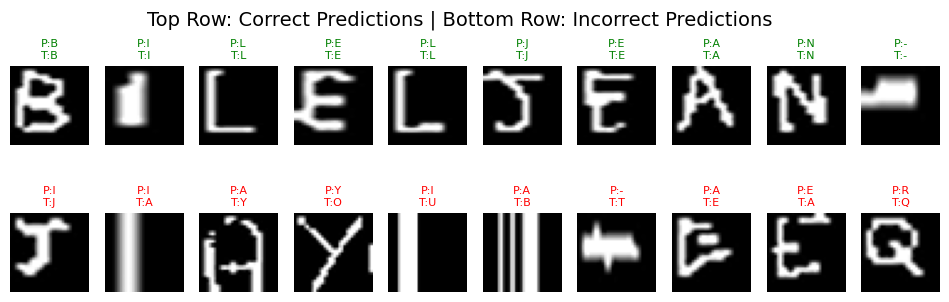

In [13]:
correct_indices = np.where(y_pred == y_val)[0]
incorrect_indices = np.where(y_pred != y_val)[0]

# Visualize first 10 correct and incorrect predictions
plt.figure(figsize=(12, 3.5))

# First row: correct predictions
for i, idx in enumerate(correct_indices[:10]):
    plt.subplot(2, 10, i+1)
    plt.imshow(x_val[idx], cmap='gray')
    plt.title(f"P:{y_pred[idx]}\nT:{y_val[idx]}", color='green', fontsize=8)
    plt.axis('off')

# Second row: incorrect predictions
for i, idx in enumerate(incorrect_indices[:10]):
    plt.subplot(2, 10, 10 + i + 1)
    plt.imshow(x_val[idx], cmap='gray')
    plt.title(f"P:{y_pred[idx]}\nT:{y_val[idx]}", color='red', fontsize=8)
    plt.axis('off')

plt.suptitle("Top Row: Correct Predictions | Bottom Row: Incorrect Predictions", fontsize=14)
plt.show()

In [ ]:
import joblib
joblib.dump(model, "SVM.pkl")
#joblib save us

['SVM.pkl']

: 